<a href="https://colab.research.google.com/github/sramakrishnan247/turbo-happiness/blob/main/DQN-MountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update 
!apt-get install -y xvfb python-opengl ff/mpeg > /dev/null 2>&1
!pip install colabgymrender
!apt update && apt install xvfb && pip3 install pyvirtualdisplay && pip install pyvirtualdisplay

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [1]:
import gym
import math
import numpy as np

In [2]:
# from colabgymrender.recorder import Recorder
# env.render()
# directory = './video'
# env = Recorder(env, directory)

## Simple MountainCar


In [3]:
import gym
import torch.nn as nn
env = gym.make("MountainCar-v0")
# env = gym.make('MountainCarContinuous-v0')

In [4]:
print(env)

<TimeLimit<MountainCarEnv<MountainCar-v0>>>


In [5]:
import copy
import torch.nn as nn
import torch
import random
import torch.nn.functional as F
import numpy as np

In [6]:
device = torch.device("cuda")
def create_new_model():
    model = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )
    target_model = copy.deepcopy(model)
    
    # Load the model onto the device defined at the very beginning (GPU or CPU)
    model.to(device)
    target_model.to(device)
    
    # Immediately set the optimizer, with which we will update the model weights
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    
    return model, target_model, optimizer

In [35]:
gamma = 0.7
def fit(batch, model, target_model, optimizer):
    state, action, reward, next_state, done = batch
    # Load the batch to the previously selected device
    state = torch.tensor(state).to(device).float()
    next_state = torch.tensor(next_state).to(device).float()
    reward = torch.tensor(reward).to(device).float()
    action = torch.tensor(action).to(device)
    done = torch.tensor(done).to(device)

    # We consider what values ​​our network should give
    target_q = torch.zeros(reward.size()[0]).float().to(device)
    with torch.no_grad():
        # Select the maximum of the Q-function values ​​for the next state
        target_q = target_model(next_state).max(1)[0].view(-1) 
        target_q[done] = 0
    target_q = reward + target_q * gamma

    # Current prediction
    print(action.unsqueeze(1))
    print(model(state))
    q = model(state).gather(1, action.unsqueeze(1))

    loss = F.mse_loss(q, target_q.unsqueeze(1))
    # loss = F.smooth_l1_loss(q, target_q.unsqueeze(1))
    # print(loss)
    # print(q, target_q,loss)
    # Clear the current gradients within the mesh
    optimizer.zero_grad()
    # Apply back propagation of the error
    loss.backward()
    # Limit the gradient values. It is necessary that the updates are not too big
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    # Making an optimization step
    optimizer.step()

In [36]:
acc_array = np.linspace(-1,1,19)
acc_array = np.round(acc_array,1)

In [37]:
def select_action(state, epsilon, model):
    if random.random() < epsilon:
        return random.randint(0, 2)
        # return random.choice(acc_array)
    return model(torch.tensor(state).to(device).float().unsqueeze(0))[0].max(0)[1].view(1, 1).item()

In [38]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, element):
        "" "Saves the item to a circular buffer" ""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = element
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        "" "Returns a random sample of the specified size" ""
        return list(zip(*random.sample(self.memory, batch_size)))
    
    def __len__(self):
        return len(self.memory)


In [39]:
# Number of model updates between target model updates
target_update = 1000
# The size of one batch that the model accepts as input
batch_size = 128

# Number of environment steps
max_steps = 100001
# Boundaries of the exploration coefficient
max_epsilon = 0.9
min_epsilon = 0.1

def train():
      # Create model and buffer
      memory = Memory(50000)
      model, target_model, optimizer = create_new_model()
      state = env.reset()
    #   print(state)
      rewards_by_target_updates = []
      for step in range(max_steps):
            # Take a step in the environment
            epsilon = max_epsilon - (max_epsilon - min_epsilon)* step / max_steps
            action = select_action(state, epsilon, model)
            # print(action)
            new_state, reward, done, _ = env.step(action)
            # modified_reward = reward + 100 * (gamma * abs (new_state [1]) - abs (state [1]))
            modified_reward = reward + 10 * abs (new_state [1])
            # print(step, action, new_state, reward, modified_reward, done)
            # Remember the experience and, if necessary, restart the environment
            memory.push((state, action, modified_reward, new_state, done))
            if done:
                  state = env.reset()
                  done = False
            else:
                  state = new_state

            # Gradient descent
            if step > batch_size:
                 fit(memory.sample(batch_size), model, target_model, optimizer)

            if step % target_update == 0:
                  target_model = copy.deepcopy(model)
      
                  #Exploitation
                  state = env.reset()
                  total_reward = 0
                  while not done:
                        action = select_action(state, 0, target_model)
                        # print(action)
                        state, reward, done, _ = env.step(action)
                        total_reward += reward

                  done = False
                  state = env.reset()
                  rewards_by_target_updates.append(total_reward)
                  print(step, total_reward)
      return rewards_by_target_updates

In [40]:
reward_list = train()

Streaming output truncated to the last 5000 lines.
        [-0.8561, -0.9108, -0.8254],
        [-0.8693, -0.9224, -0.8398],
        [-0.9139, -0.9621, -0.8902],
        [-0.9146, -0.9627, -0.8909],
        [-0.8338, -0.8957, -0.8043],
        [-0.8693, -0.9223, -0.8402],
        [-0.9188, -0.9663, -0.8961],
        [-0.9058, -0.9546, -0.8818]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[1],
        [1],
        [2],
        [2],
        [1],
        [0],
        [2],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [2],
        [1],
        [1],
        [2],
        [0],
        [1],
        [0],
        [0],
        [0],
        [2],
        [2],
        [0],
        [1],
        [1],
        [0],
        [0],
        [2],
        [2],
        [2],
        [1],
        [1],
        [2],
        [0],
        [1],
        [0],
        [1],
        [0],
        [2],
        [0],

KeyboardInterrupt: ignored

In [27]:
import numpy as np
import matplotlib.pyplot as plt


yy = np.array(reward_list)
xx = np.array([i for i in range(1,len(yy)+1)])
plt.plot(xx,yy)

NameError: ignored

In [28]:
env.play()

AttributeError: ignored

##Continuous

In [21]:
env = gym.make('MountainCarContinuous-v0')
directory = './video'
# env._max_episode_steps = 50000
obs = env.reset()
print(obs)
print(env._max_episode_steps)


[-0.52124574  0.        ]
999


In [22]:
print('action_space',env.action_space)
print(env.observation_space.low) 
print(env.observation_space.high) 


action_space Box(-1.0, 1.0, (1,), float32)
[-1.2  -0.07]
[0.6  0.07]


In [7]:
env = Recorder(env, directory)

In [11]:
class MountainCarContinuous:
    def __init__(self, epsilon, alpha, gamma, env):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        #Reset env
        self.env.reset()

        self.min_pos = -1.2
        self.max_pos = 0.6
        self.min_vel = -0.07
        self.max_vel = 0.07
        self.min_acc = -1.0
        self.max_acc = 1.0

        self.pos_array = np.linspace(self.min_pos,self.max_pos,10)
        self.vel_array = np.linspace(self.min_vel,self.max_vel,15)
        self.acc_array = np.linspace(self.min_acc,self.max_acc,20)

        state_len = len(self.pos_array)*len(self.vel_array)
        action_len = len(self.acc_array)

        self.Q = np.zeros([state_len,action_len])

    def get_Q_index(self,state):
        for i in range(len(self.pos_array)):
            if self.pos_array[i] <= state[0] < self.pos_array[i+1]:
                for j in range(len(self.vel_array)):
                    if self.vel_array[j] <= state[1] <self.vel_array[j+1]:
                        return len(self.vel_array)*i + j


    def get_action_index(self,action):
        for i in range(len(self.acc_array)):
            if self.acc_array[i] <= action < self.acc_array[i+1]:
                return i


    def q_learning(self,episodes,rendering = True):
        overall_max_score = -math.inf
        overall_max_height = -math.inf
        scores = []
        heights = []

        for i in range(1,episodes):
            obs = self.env.reset()
            state = self.get_Q_index(obs)
            done = False
            total_score = 0
            max_height = -math.inf
            
            self.epsilon -= self.epsilon/episodes
            if i % 100:
                self.alpha -= 0.05
                if self.alpha <= 0:
                    self.alpha = 0.5
            while not done:
                # self.env.render() if rendering else 0  
                if np.random.uniform(0,1) < self.epsilon:
                    action = self.get_action_index(self.env.action_space.sample())
                else:
                    action = np.argmax(self.Q[state])

                next_obs, reward, done, info = self.env.step([self.acc_array[action]])


                
                next_state = self.get_Q_index(next_obs)
                

                #Method 1
                #Converges
                modified_reward = reward + 100 * self.gamma * (abs(next_obs[1]) - abs(obs[1]))  
                self.Q[state][action] = (1-self.alpha)*self.Q[state][action] + \
                                        self.alpha*(modified_reward + self.gamma*np.max(self.Q[next_state]) - self.Q[state][action])


                #Method 2
                #Does not converge
                # best_next_action = np.argmax(self.Q[next_state])    
                # td_target = reward + self.gamma * self.Q[next_state][best_next_action]
                # td_delta = td_target - self.Q[state][action]
                # self.Q[state][action] += self.alpha * td_delta
                # self.Q[state][action] += \
                #         self.alpha*(reward + self.gamma*np.max(self.Q[next_state]) - self.Q[state][action])

                state = next_state

                total_score += reward
                max_height = max(max_height,next_obs[0])

            scores.append(total_score)
            heights.append(max_height)
            overall_max_score = max(overall_max_score, total_score)
            overall_max_height = max(overall_max_height, max_height)
            # self.env.play()

            print(i, self.epsilon, total_score, overall_max_score, max_height, overall_max_height)

            self.rewards_per_episode = scores
            self.height_per_episode = heights


        

In [12]:
agent = MountainCarContinuous(epsilon=0.1, alpha=0.5, gamma=0.7, env=env)

In [13]:
agent.q_learning(40)

1 0.0975 -63.52105263157929 -63.52105263157929 -0.13494217095535224 -0.13494217095535224
2 0.09506250000000001 -58.91385041551272 -58.91385041551272 0.0001928680407883329 0.0001928680407883329
3 0.09268593750000001 -53.84792243767328 -53.84792243767328 0.07808213915195798 0.07808213915195798
4 0.09036878906250001 -52.770914127424014 -52.770914127424014 0.06879553010869811 0.07808213915195798
5 0.08810956933593751 -49.909972299169034 -49.909972299169034 0.06548150873641614 0.07808213915195798
6 0.08590683010253908 -54.164819944598406 -49.909972299169034 0.11125236707454944 0.11125236707454944
7 0.0837591593499756 -47.83130193905823 -47.83130193905823 0.08704312245352576 0.11125236707454944
8 0.08166518036622622 -47.50554016620506 -47.50554016620506 0.086404866838594 0.11125236707454944
9 0.07962355085707057 -50.616897506925284 -47.50554016620506 0.07612252263064645 0.11125236707454944
10 0.0776329620856438 -52.07950138504163 -47.50554016620506 0.0845800221663847 0.11125236707454944
11 0

In [14]:
env.play()

100%|██████████| 223/223 [00:00<00:00, 343.13it/s]


In [15]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'episode')

Text(0, 0.5, 'rewards')

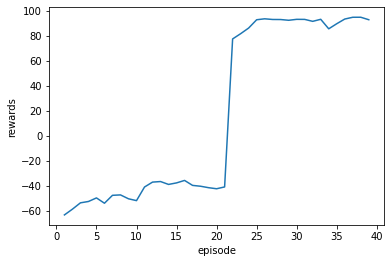

In [16]:
y = agent.rewards_per_episode
x = [i for i in range(1, len(y)+1)]
plt.xlabel('episode')
plt.ylabel('rewards')
plt.plot(x,y)

Text(0.5, 0, 'episode')

Text(0, 0.5, 'max_height')

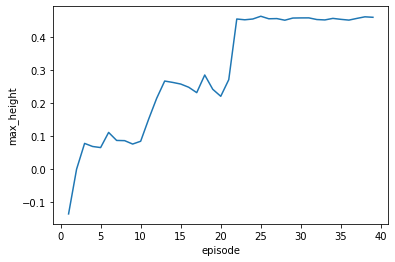

In [17]:
y = agent.height_per_episode
x = [i for i in range(1, len(y)+1)]
plt.xlabel('episode')
plt.ylabel('max_height')
plt.plot(x,y)